# Preference Learning - Part III
## 1. Groups' Price Responsiveness - K-mean based
## 2. Groups' Price Responsiveness - GMM based 

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import seaborn as sns
import math
from pandas.io.json import json_normalize #package for flattening json in pandas df
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

In [ ]:
# Import all preprocessed data necessary for the analysis
df_tou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_tou2013_1h.csv")
df_Ntou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_Ntou2013_1h.csv")
df_wea1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\weather\\LondonWeather2013_interpolated.csv")
df_tariff_1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\df_tariff_1h.csv")

In [3]:
import os
os.getcwd()

'/Users/Rockwell/Documents/GitHub/Demand-Response'

In [4]:
# for ios system, import all data necessary for the analysis
df_tou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_tou2013_1h.csv')
df_Ntou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_Ntou2013_1h.csv')
df_wea1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/LondonWeather2013_interpolated.csv')
df_tariff_1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/df_tariff_1h.csv')

In [5]:
# first, create a list of days that belongs to event days
event_days = set()
event_series = df_tariff_1h[df_tariff_1h.Event_tags.notnull()].GMT
for i in event_series:
    event_days.add(datetime.strptime(i[:10], "%Y-%m-%d" ).date()) # add all event dates to the set
df_help = pd.DataFrame(pd.to_datetime(df_tariff_1h.GMT).dt.date) #str to datatime and extract date then make it to dataframe
# df_help[df_help['GMT'].isin(event_days)] #this shows the event days
# we can use ~df_help['GMT'].isin(event_days) to generate any non-flexible period items

# create TOU and non-TOU demand data in non-flexible hours
df_wea1h_nf = df_wea1h[~df_help['GMT'].isin(event_days)]
df_Ntou1h_nf = df_Ntou1h[~df_help['GMT'].isin(event_days)]
df_tou1h_nf = df_tou1h[~df_help['GMT'].isin(event_days)]

# create event data
df_tariff_1h_event = df_tariff_1h[df_tariff_1h.GMT.isin(event_series)]
df_wea1h_event = df_wea1h[df_wea1h.GMT.isin(event_series)]
df_tou1h_event = df_tou1h[df_tou1h.GMT.isin(event_series)]

In [24]:
# seperate the above data set based on the seasonal effect
# i.e., months of 11, 12, 1, 2, 3 are in a group - cold season
# months of 4, 5, 6, 7, 8, 9, 10 are in another group - warm season
cold_season = [11, 12, 1, 2, 3]
warm_season = [4, 5, 6, 7, 8, 9, 10]
df_help_season = pd.DataFrame(pd.to_datetime(df_wea1h_nf.GMT).dt.month)
df_wea1h_nf_cold = df_wea1h_nf[df_help_season['GMT'].isin(cold_season)]
df_wea1h_nf_warm = df_wea1h_nf[df_help_season['GMT'].isin(warm_season)]
df_Ntou1h_nf_cold = df_Ntou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_Ntou1h_nf_warm = df_Ntou1h_nf[df_help_season['GMT'].isin(warm_season)]
df_tou1h_nf_cold = df_tou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_tou1h_nf_warm = df_tou1h_nf[df_help_season['GMT'].isin(warm_season)]

df_help_season_event = pd.DataFrame(pd.to_datetime(df_wea1h_event.GMT).dt.month)
df_wea1h_event_cold = df_wea1h_event[df_help_season_event['GMT'].isin(cold_season)]
df_wea1h_event_warm = df_wea1h_event[df_help_season_event['GMT'].isin(warm_season)]
df_tou1h_event_cold = df_tou1h_event[df_help_season_event['GMT'].isin(cold_season)]
df_tou1h_event_warm = df_tou1h_event[df_help_season_event['GMT'].isin(warm_season)]
df_tariff_1h_event_cold = df_tariff_1h_event[df_help_season_event['GMT'].isin(cold_season)]
df_tariff_1h_event_warm = df_tariff_1h_event[df_help_season_event['GMT'].isin(warm_season)]

## 1. Groups' Price Responsiveness - K-mean based

The way we analyze the group price responsiveness has three steps:

1) for each hosehold group, build a new dataframe, the first column is GMT, the next columns are user ids in the group, the next column is temperature, then the price, day of a week, hour of a day, then the predicted consumption, and last the price responsiveness

2) build a function that can generate predicted consumption based on the day of a week, temp, hour to choose the coefficients and then make a prediction.

3) plot the properties based on from the smallest unit (day of week, hour, temp) to (day of week, hour), (day of week, temp), (hour, temp), (day of week), (hour), (temp) so we will have very comprehensive price responsiveness of three different groups


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
n = 3 # cluster numbers
n_house = 1025 # total household numbers
houseLabel = [] # store the 24hour group labels for each hoursehold
for i in range(1025):
    houseLabel.append('')
houseLabel = np.array(houseLabel)
cons_type = ['High Consumption', 'Medium Consumption', 'Low Consumption']
fig_all = plt.figure(figsize = (13,90))
for i in range(24):
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and fill in null value with mean
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        houseLabel = np.core.defchararray.add(houseLabel, kmeans.labels_.astype('str'))
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.fillna(x.mean()).transpose() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans = KMeans(n_clusters = n, init='k-means++').fit(principleDf_nstd.iloc[:,:3])
        cluster_dict = {}
        houseLabel = np.core.defchararray.add(houseLabel, kmeans.labels_.astype('str'))
# We obtain the house Label shown below
# print(houseLabel)

# Group the house based on their 24 hour labels
houseLableDf = pd.DataFrame()
houseLableDf['House'] = df_tou1h_nf_cold.columns[1:]
houseLableDf['Label'] = houseLabel
houseGroupDf = houseLableDf.groupby('Label').size().reset_index(name='counts')
houseGroupDf = houseGroupDf.sort_values(by=['counts'], ascending=False)
houseGroupDf

Label  counts
96   001000110110000000220001     410
378  210111021002221112002220      28
110  001000110110000002220001      10
54   001000110010000000220001       7
157  001000111002221112002220       7
90   001000110110000000200001       6
89   001000110110000000020001       6
372  210111011002221112002220       5
419  211000110110000000220001       5
270  122222202221112221111112       5
294  201000110110000000220001       5
11   001000010110000000220001       5
101  001000110110000000222001       4
109  001000110110000002020001       4
162  001000111010000000220001       4
418  211000110110000000220000       4
26   001000110000000000220001       4
210  001001110110000000220001       4
119  001000110110000100220001       4
114  001000110110000012000001       3
172  001000111110000000220001       3
34   001000110002000000220001       3
120  001000110110000110220001       3
413  211000110002221112002220       3
68   001000110100000000220001       3
113  001000110110000010220001       3
282  201000110002221112002220       3
137  001000110110220000220001       3
313  201000111002221112002220       3
156  001000111002221112002201       3
..                        ...     ...
136  001000110110200012220001       1
134  001000110110021112002220       1
133  001000110110021100220001       1
132  001000110110021000220001       1
160  001000111002221112220001       1
161  001000111010000000200001       1
164  001000111010000012020001       1
165  001000111010000012220201       1
190  001000121010021002000001       1
189  001000121002221112002221       1
188  001000121002221112002220       1
185  001000121002221111002001       1
184  001000121002221102002201       1
183  001000121002221012020001       1
182  001000121002220112002201       1
181  001000120110020000220001       1
180  001000120110000112002201       1
179  001000120110000002220001       1
177  001000120110000000202201       1
176  001000120002000112002221       1
175  001000111200000000220001       1
174  001000111110221112002001       1
173  001000111110000012002221       1
171  001000111102221112002221       1
170  001000111102220000002220       1
169  001000111010221112220001       1
168  001000111010221002220001       1
167  001000111010221000000221       1
166  001000111010200000220001       1
451  220112222221112221102220       1

[452 rows x 2 columns]

<Figure size 936x6480 with 0 Axes>

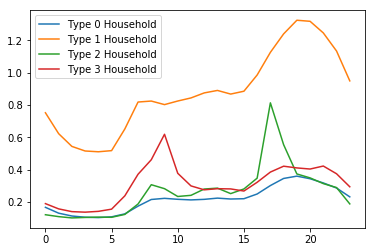

In [8]:
for i in range(4):
    load = []
    for j in range(24):
        if j <= 9:
            x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(j) + ':00:00')]
            x.set_index('GMT', inplace = True)
            x = x.fillna(x.mean())
            x = x[list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[i]].House)]
            load.append(x.mean().mean())
        else:
            x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(j) + ':00:00')]
            x.set_index('GMT', inplace = True)
            x = x.fillna(x.mean())
            x = x[list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[i]].House)]
            load.append(x.mean().mean())
    plt.plot(load, label = 'Type ' + str(i) + ' Household')
plt.legend()
plt.show()

In [122]:
# Type 0 household
# build a new dataframe with columns: GMT, user ids in the group
df_type0 = df_tou1h_event_cold[['GMT'] + list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[0]].House)]
df_type0 = pd.merge(df_type0, df_wea1h_event_cold, on = 'GMT') # add weather
df_type0 = pd.merge(df_type0, df_tariff_1h_event_cold, on = 'GMT') # add price
df_type0['Day of week'] = pd.to_datetime(df_type0.GMT).dt.dayofweek # add day of week
df_type0['Hour of day'] = pd.to_datetime(df_type0.GMT).dt.hour # add hour of day
df_type0['Household type'] = 0

# Type 1 household
# build a new dataframe with columns: GMT, user ids in the group
df_type1 = df_tou1h_event_cold[['GMT'] + list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[1]].House)]
df_type1 = pd.merge(df_type1, df_wea1h_event_cold, on = 'GMT') # add weather
df_type1 = pd.merge(df_type1, df_tariff_1h_event_cold, on = 'GMT') # add price
df_type1['Day of week'] = pd.to_datetime(df_type1.GMT).dt.dayofweek # add day of week
df_type1['Hour of day'] = pd.to_datetime(df_type1.GMT).dt.hour # add hour of day
df_type1['Household type'] = 1

# Type 2 household
# build a new dataframe with columns: GMT, user ids in the group
df_type2 = df_tou1h_event_cold[['GMT'] + list(houseLableDf[houseLableDf.Label == houseGroupDf.Label.iloc[2]].House)]
df_type2 = pd.merge(df_type2, df_wea1h_event_cold, on = 'GMT') # add weather
df_type2 = pd.merge(df_type2, df_tariff_1h_event_cold, on = 'GMT') # add price
df_type2['Day of week'] = pd.to_datetime(df_type2.GMT).dt.dayofweek # add day of week
df_type2['Hour of day'] = pd.to_datetime(df_type2.GMT).dt.hour # add hour of day
df_type2['Household type'] = 2

With the household type and feature data ready, we need to build functions that can predict the consumptions during these time periods. Since we are considering group properties, the above users are all in the first group, for each time period, we only have one consumption predicted for the whole group, but since the regression coefficients depend on day of week, temperature and hour of day, so it should be quite different for different time.

In [ ]:
def predict(dfRegression, dayOfWeek, hour, temperature):
    '''
    Predict the consumption duruing event time based on 
    the regression, day of week, hour of a day and temperature
    '''
    weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    output = dfRegression[weeks[dayOfWeek]].iloc[hour](temperature)
    return output

In [125]:
# store the regression coefficients
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_regression_0 = {} # store the regression coefficients
df_regression_1 = {}
df_regression_2 = {}
# df_regression_3 = {}
lm = LinearRegression()
for g in range(3): # doing this for three groups
    for day_of_week in range(7):
        coef_temp = []
        for i in range(24):
            if i <= 9:
                z = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
                y_temp = z[['GMT'] + list(houseLableDf[(houseLableDf.Label == houseGroupDf.Label.iloc[g]) ].House)]
                y = y_temp[pd.to_datetime(z.GMT).dt.dayofweek == day_of_week] # find the users' data for Monday
                y.set_index('GMT', inplace = True)
                y = y.fillna(y.mean()).values
                y = np.reshape(y, y.shape[0] * y.shape[1], order = 'F') # reconstruct the y variable
                x = df_wea1h_nf_cold.TempC[(df_wea1h.GMT.str.contains('0' + str(i) + ':00:00')) & (pd.to_datetime(z.GMT).dt.dayofweek == day_of_week)].values
                x = np.tile(x, reps = sum(houseLableDf.Label == houseGroupDf.Label.iloc[g])) # reconstruct the x variable
                z = np.polyfit(x, y, 2)
                p = np.poly1d(z)
                coef_temp.append(p)
            else:
                z = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
                y_temp = z[['GMT'] + list(houseLableDf[(houseLableDf.Label == houseGroupDf.Label.iloc[g]) ].House)]
                y = y_temp[pd.to_datetime(z.GMT).dt.dayofweek == day_of_week] # find the users' data for Monday
                y.set_index('GMT', inplace = True)
                y = y.fillna(y.mean()).values
                y = np.reshape(y, y.shape[0] * y.shape[1], order = 'F') # reconstruct the y variable

                x = df_wea1h_nf_cold.TempC[(df_wea1h.GMT.str.contains(str(i) + ':00:00')) & (pd.to_datetime(z.GMT).dt.dayofweek == day_of_week)].values
                x = np.tile(x, reps = sum(houseLableDf.Label == houseGroupDf.Label.iloc[g])) # reconstruct the x variable
                z = np.polyfit(x, y, 2)
                p = np.poly1d(z)
                coef_temp.append(p)
        if g == 0:
            df_regression_0[weeks[day_of_week]] = coef_temp
        elif g == 1:
            df_regression_1[weeks[day_of_week]] = coef_temp
        else:
            df_regression_2[weeks[day_of_week]] = coef_temp
df_regression_0 = pd.DataFrame(df_regression_0) # type 0 regression coefficient
df_regression_1 = pd.DataFrame(df_regression_1) # type 1 
df_regression_2 = pd.DataFrame(df_regression_2) # type 2 

In [126]:
# type 0 event time consumption prediction
pred_result = []
for i in range(df_type0.shape[0]):
    pred_result.append(predict(df_regression_0, df_type0['Day of week'].iloc[i], df_type0['Hour of day'].iloc[i], df_type0['TempC'].iloc[i]))
df_type0['Predicted consumption'] = pred_result
# price responsiveness elementwise
df_type0_res = df_type0.copy()
df_type0_res.iloc[:,1:houseGroupDf.counts.iloc[0] + 1] = df_type0.iloc[:,1:houseGroupDf.counts.iloc[0] + 1].sub(df_type0['Predicted consumption'], axis = 0)

# type 1 event time consumption prediction
pred_result = []
for i in range(df_type1.shape[0]):
    pred_result.append(predict(df_regression_1, df_type1['Day of week'].iloc[i], df_type1['Hour of day'].iloc[i], df_type1['TempC'].iloc[i]))
df_type1['Predicted consumption'] = pred_result

# price responsiveness elementwise
df_type1_res = df_type1.copy()
df_type1_res.iloc[:,1:houseGroupDf.counts.iloc[1] + 1] = df_type1.iloc[:,1:houseGroupDf.counts.iloc[1] + 1].sub(df_type1['Predicted consumption'], axis = 0)

# type 2 event time consumption prediction
pred_result = []
for i in range(df_type2.shape[0]):
    pred_result.append(predict(df_regression_2, df_type2['Day of week'].iloc[i], df_type2['Hour of day'].iloc[i], df_type2['TempC'].iloc[i]))
df_type2['Predicted consumption'] = pred_result

# price responsiveness elementwise
df_type2_res = df_type2.copy()
df_type2_res.iloc[:,1:houseGroupDf.counts.iloc[2] + 1] = df_type2.iloc[:,1:houseGroupDf.counts.iloc[2] + 1].sub(df_type2['Predicted consumption'], axis = 0)

To visualize the price responsiveness, we need to reformat the data and melt them to a long dataframe, and all the user ID columns will be extracted to form a individual dataframe with adding household group label and we concatenate all of them in a long dataframe.

In [140]:
houseGroupDf.counts.iloc[0]

410

In [137]:
df_type0_res.head()

GMT     D0000     D0001     D0005     D0007     D0010  \
0  2013-01-04 14:00:00 -0.084761  0.052239  0.005239 -0.038761 -0.168761   
1  2013-01-04 15:00:00 -0.095933  0.823067  0.451067 -0.040933 -0.162933   
2  2013-01-04 16:00:00  1.132319  0.085319  0.315319  0.366319 -0.202681   
3  2013-01-07 23:00:00  0.092587  0.122587  0.077587  0.034587 -0.195413   
4  2013-01-08 00:00:00 -0.066445  0.064555  0.112555  0.104555 -0.140445   

      D0012     D0013     D0016     D0018          ...               D1023  \
0  0.405239  0.066239 -0.117761 -0.099761          ...           -0.173761   
1  0.836067  0.735067 -0.130933  0.168067          ...           -0.160933   
2  0.554319  0.508319 -0.172681  0.405319          ...           -0.003681   
3  0.347587 -0.102413 -0.124413  0.303587          ...           -0.095413   
4  0.043555 -0.061445 -0.094445  0.009555          ...           -0.059445   

      D1024      TempC      TempF   Price  Event_tags  Day of week  \
0 -0.054761  10.333333  51.000000  0.0399          L3            4   
1 -0.105933  10.000000  51.000000  0.0399          L3            4   
2 -0.042681   9.333333  49.333333  0.0399          L3            4   
3  0.245587   7.000000  44.000000  0.6720          H3            0   
4 -0.015445   7.000000  44.000000  0.6720          H3            1   

   Hour of day  Household type  Predicted consumption  
0           14               0               0.186761  
1           15               0               0.192933  
2           16               0               0.228681  
3           23               0               0.221413  
4            0               0               0.164445  

[5 rows x 419 columns]

In [156]:
df_type0_res

GMT     D0000     D0001     D0005     D0007     D0010  \
0    2013-01-04 14:00:00 -0.084761  0.052239  0.005239 -0.038761 -0.168761   
1    2013-01-04 15:00:00 -0.095933  0.823067  0.451067 -0.040933 -0.162933   
2    2013-01-04 16:00:00  1.132319  0.085319  0.315319  0.366319 -0.202681   
3    2013-01-07 23:00:00  0.092587  0.122587  0.077587  0.034587 -0.195413   
4    2013-01-08 00:00:00 -0.066445  0.064555  0.112555  0.104555 -0.140445   
5    2013-01-08 01:00:00 -0.033424  0.034576  0.060576  0.041576 -0.100424   
6    2013-01-10 02:00:00 -0.014933  0.009067  0.729067  0.062067 -0.088933   
7    2013-01-10 03:00:00 -0.015324  0.003676  0.382676  0.052676 -0.082324   
8    2013-01-10 04:00:00  0.113252 -0.032748  0.199252  0.094252 -0.086748   
9    2013-01-11 11:00:00 -0.100935 -0.006935  0.011065  0.116065 -0.185935   
10   2013-01-11 12:00:00 -0.144464 -0.026464 -0.037464  0.187536 -0.083464   
11   2013-01-11 13:00:00 -0.103057 -0.005057 -0.070057  0.342943 -0.134057   
12   2013-01-13 05:00:00  0.131004 -0.016996  0.061004  0.038004 -0.086996   
13   2013-01-13 06:00:00 -0.026613  0.038387  0.033387  0.285387 -0.087613   
14   2013-01-13 07:00:00 -0.080359 -0.070359  0.037641  0.299641 -0.131359   
15   2013-01-13 08:00:00 -0.112905  0.254095  0.078095  0.051095 -0.180905   
16   2013-01-13 09:00:00 -0.146042  0.108958 -0.054042  0.010958 -0.229042   
17   2013-01-13 10:00:00 -0.185176  0.119824 -0.062176  0.066824 -0.228176   
18   2013-01-16 23:00:00 -0.172620  0.224380  0.188380  0.145380 -0.246620   
19   2013-01-17 00:00:00 -0.117406 -0.091406  0.128594  0.111594 -0.183406   
20   2013-01-17 01:00:00 -0.071150 -0.029150  0.003850  0.095850 -0.130150   
21   2013-01-19 05:00:00 -0.027990 -0.029990  0.080010  0.276010 -0.079990   
22   2013-01-19 06:00:00 -0.024402 -0.011402  0.017598  0.236598 -0.100402   
23   2013-01-19 07:00:00 -0.060056 -0.050056  0.016944  0.159944 -0.137056   
24   2013-01-19 08:00:00 -0.147660 -0.034660  0.137340  0.188340 -0.183660   
25   2013-01-19 09:00:00 -0.115253  0.147747  0.156747  0.143747 -0.227253   
26   2013-01-19 10:00:00  0.688811  0.225811  0.036811 -0.031189 -0.251189   
27   2013-01-19 11:00:00  0.325001 -0.178999  0.089001  0.108001 -0.242999   
28   2013-01-19 12:00:00  0.074385  0.003385  0.083385  0.078385 -0.163615   
29   2013-01-19 13:00:00 -0.159550  0.082450  0.088450  0.053450 -0.243550   
..                   ...       ...       ...       ...       ...       ...   
549  2013-12-19 14:00:00 -0.093926  0.100074  0.126074  0.088074 -0.188926   
550  2013-12-19 15:00:00 -0.102953 -0.050953  0.087047  0.169047 -0.192953   
551  2013-12-19 16:00:00 -0.083409 -0.103409  0.169591  0.229591 -0.225409   
552  2013-12-19 17:00:00  0.231639  0.242639  0.123639  0.473639 -0.289361   
553  2013-12-19 18:00:00  0.206326  0.200326  0.088326  0.282326 -0.319674   
554  2013-12-19 19:00:00  0.284803  0.232803  0.056803  0.143803 -0.361197   
555  2013-12-19 20:00:00  0.153681  0.051681  0.158681  0.091681 -0.332319   
556  2013-12-19 21:00:00  0.147610  0.027610  0.107610  0.037610 -0.298390   
557  2013-12-19 22:00:00  0.124200  0.165200  0.146200  0.022200 -0.271800   
558  2013-12-19 23:00:00  0.038926  0.221926  0.175926  0.015926 -0.219074   
559  2013-12-20 00:00:00 -0.065423  0.061577  0.240577  0.092577 -0.136423   
560  2013-12-20 01:00:00 -0.032547 -0.031547  0.220453  0.046453 -0.098547   
561  2013-12-20 02:00:00 -0.009726 -0.026726  0.161274  0.081274 -0.094726   
562  2013-12-20 03:00:00  0.015081 -0.019919  0.113081  0.117081 -0.083919   
563  2013-12-20 04:00:00  0.265193 -0.000807  0.057193  0.038193 -0.074807   
564  2013-12-26 08:00:00 -0.131882  0.019118 -0.065882  0.113118 -0.211882   
565  2013-12-26 09:00:00  0.059012  0.092012 -0.056988  0.085012 -0.204988   
566  2013-12-26 10:00:00 -0.050319  0.169681 -0.030319  0.131681 -0.181319   
567  2013-12-29 17:00:00  0.645292  0.157292  0.125292  0.145292 -0.280708   
568  2013-12-29 18:00:00  0.351959  0.02295

In [181]:
# select each user ID and form a seperate dataframe
# first change all the user ID to "Consumption"
new_col = ['GMT']
for i in range(0, houseGroupDf.counts.iloc[0]):
    new_col.append('Consumption')
new_col = new_col + list(df_type0_res.columns)[-8:] # the new column names
df_type0_res.columns = new_col
df_all_res_long = pd.DataFrame()
for i in range(1, houseGroupDf.counts.iloc[0] + 1):
    df_all_res_long = df_all_res_long.append(df_type0_res.iloc[:,[0,i,-8,-7,-6,-5,-4,-3,-2,-1]], ignore_index = True)

new_col = ['GMT']
for i in range(0, houseGroupDf.counts.iloc[1]): # for renaming the second type
    new_col.append('Consumption')
new_col = new_col + list(df_type1_res.columns)[-8:] # the new column names
df_type1_res.columns = new_col
for i in range(1, houseGroupDf.counts.iloc[1] + 1):
    df_all_res_long = df_all_res_long.append(df_type1_res.iloc[:,[0,i,-8,-7,-6,-5,-4,-3,-2,-1]], ignore_index = True)

new_col = ['GMT']
for i in range(0, houseGroupDf.counts.iloc[2]): # for renaming the third type
    new_col.append('Consumption')
new_col = new_col + list(df_type2_res.columns)[-8:] # the new column names
df_type2_res.columns = new_col
for i in range(1, houseGroupDf.counts.iloc[2] + 1):
    df_all_res_long = df_all_res_long.append(df_type2_res.iloc[:,[0,i,-8,-7,-6,-5,-4,-3,-2,-1]], ignore_index = True)

# for clearer visulization, round the temperatures
df_all_res_long['TempC'] = df_all_res_long.TempC.round(0)
df_all_res_long['TempF'] = df_all_res_long.TempF.round(0)
df_all_res_long # ready for the price responsiveness analysis

GMT  Consumption  TempC  TempF   Price Event_tags  \
0       2013-01-04 14:00:00    -0.084761   10.0   51.0  0.0399         L3   
1       2013-01-04 15:00:00    -0.095933   10.0   51.0  0.0399         L3   
2       2013-01-04 16:00:00     1.132319    9.0   49.0  0.0399         L3   
3       2013-01-07 23:00:00     0.092587    7.0   44.0  0.6720         H3   
4       2013-01-08 00:00:00    -0.066445    7.0   44.0  0.6720         H3   
5       2013-01-08 01:00:00    -0.033424    7.0   43.0  0.6720         H3   
6       2013-01-10 02:00:00    -0.014933    1.0   34.0  0.0399         L3   
7       2013-01-10 03:00:00    -0.015324    1.0   34.0  0.0399         L3   
8       2013-01-10 04:00:00     0.113252    1.0   34.0  0.0399         L3   
9       2013-01-11 11:00:00    -0.100935    3.0   37.0  0.6720         H3   
10      2013-01-11 12:00:00    -0.144464    4.0   39.0  0.6720         H3   
11      2013-01-11 13:00:00    -0.103057    4.0   39.0  0.6720         H3   
12      2013-01-13 05:00:00     0.131004   -2.0   29.0  0.6720         H6   
13      2013-01-13 06:00:00    -0.026613   -2.0   29.0  0.6720         H6   
14      2013-01-13 07:00:00    -0.080359   -1.0   30.0  0.6720         H6   
15      2013-01-13 08:00:00    -0.112905   -1.0   31.0  0.6720         H6   
16      2013-01-13 09:00:00    -0.146042    0.0   32.0  0.6720         H6   
17      2013-01-13 10:00:00    -0.185176    1.0   33.0  0.6720         H6   
18      2013-01-16 23:00:00    -0.172620   -5.0   22.0  0.6720         H3   
19      2013-01-17 00:00:00    -0.117406   -6.0   21.0  0.6720         H3   
20      2013-01-17 01:00:00    -0.071150   -5.0   22.0  0.6720         H3   
21      2013-01-19 05:00:00    -0.027990   -2.0   29.0  0.0399         CM   
22      2013-01-19 06:00:00    -0.024402   -2.0   29.0  0.0399         CM   
23      2013-01-19 07:00:00    -0.060056   -2.0   30.0  0.0399         CM   
24      2013-01-19 08:00:00    -0.147660   -1.0   30.0  0.0399         CM   
25      2013-01-19 09:00:00    -0.115253   -1.0   31.0  0.0399         CM   
26      2013-01-19 10:00:00     0.688811   -1.0   31.0  0.0399         CM   
27      2013-01-19 11:00:00     0.325001   -0.0   32.0  0.0399         CM   
28      2013-01-19 12:00:00     0.074385    0.0   32.0  0.0399         CM   
29      2013-01-19 13:00:00    -0.159550    0.0   32.0  0.0399         CM   
...                     ...          ...    ...    ...     ...        ...   
259362  2013-12-19 14:00:00     0.026042    5.0   42.0  0.0399        L24   
259363  2013-12-19 15:00:00     0.752225    5.0   42.0  0.0399        L24   
259364  2013-12-19 16:00:00     1.037395    5.0   42.0  0.0399        L24   
259365  2013-12-19 17:00:00     1.230750    5.0   42.0  0.0399        L24   
259366  2013-12-19 18:00:00     0.048408    5.0   42.0  0.0399        L24   
259367  2013-12-19 19:00:00    -0.138476    5.0   42.0  0.0399        L24   
259368  2013-12-19 20:00:00    -0.088367    5.0   42.0  0.0399        L24   
259369  2013-12-19 21:00:00    -0.029095    5.0   42.0  0.0399        L24   
259370  2013-12-19 22:00:00    -0.043453    5.0   41.0  0.0399        L24   
259371  2013-12-19 23:00:00     0.079350    5.0   41.0  0.0399        L24   
259372  2013-12-20 00:00:00     0.057260    5.0   40.0  0.0399        L24   
259373  2013-12-20 01:00:00    -0.011436    5.0   40.0  0.0399        L24   
259374  2013-12-20 02:00:00     0.017666    5.0   40.0  0.0399        L24   
259375  2013-12-20 03:00:00     0.057762    5.0   40.0  0.0399        L24   
259376  2013-12-20 04:00:00    -0.012526    5.0   40.0  0.0399        L24   
259377  2013-12-26 08:00:00    -0.061602    4.0   40.0  0.0399         L3   
259378  2013-12-26 09:00:00    -0.096392    4.0   40.0  0.0399         L3   
259379  2013-12-26 10:00:00    -0.150750    4.0   40.0  0.0399         L3   
259380  2013-12-29 17:00:00    -0.255094    3.0   38.0  0.0399        L12   
259381  2013-12-29 18:00:00    -0.164974    3.0   38.0  0.0399        L12   
259382  2013-12-29 1

Then plot the properties based on from the smallest unit (day of week, hour, temp) to (day of week, hour), (day of week, temp), (hour, temp), (day of week), (hour), (temp) for different prices (high and low) so we will have very comprehensive price responsiveness of three different groups

a) Day of week - hour - temperature : prices

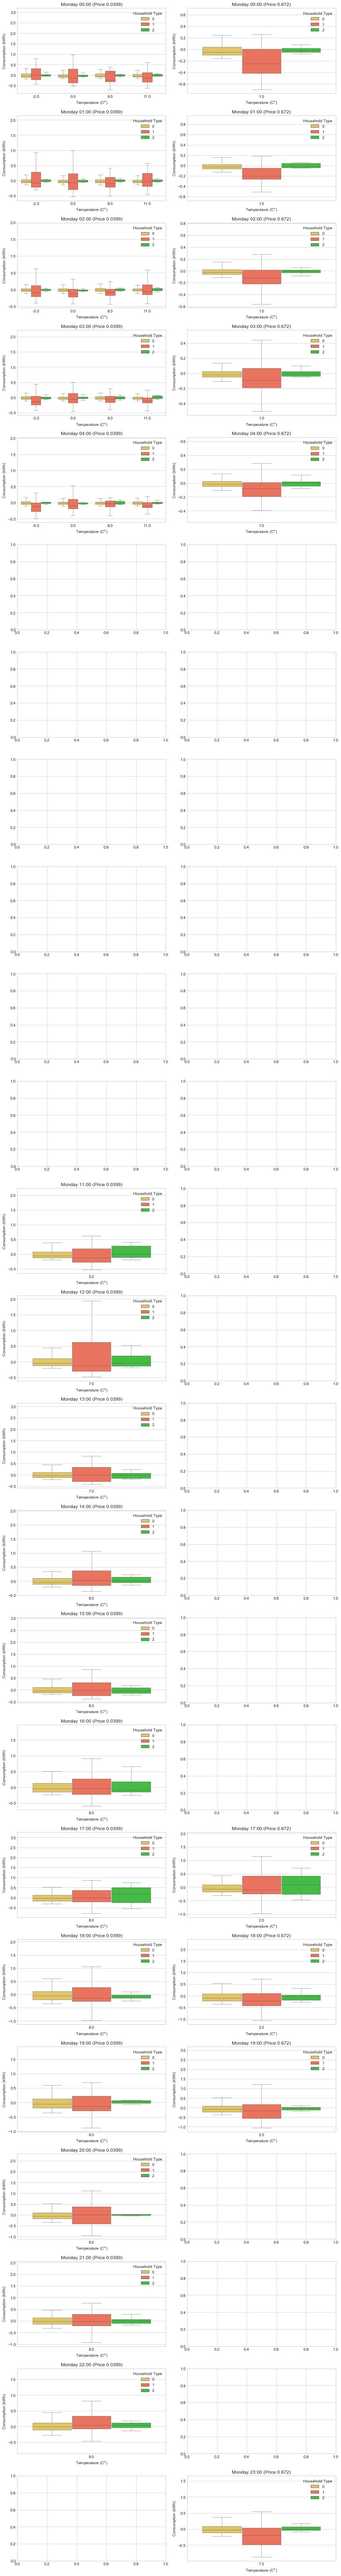

In [310]:
# Monday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 0 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                if i == 0:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 1:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 2:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 3:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 4:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 5:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 6:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 7:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 8:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                elif i == 9:
                    ax_Ntou[-1].set(ylim = (-0.8, 1))
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)    
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5) 
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

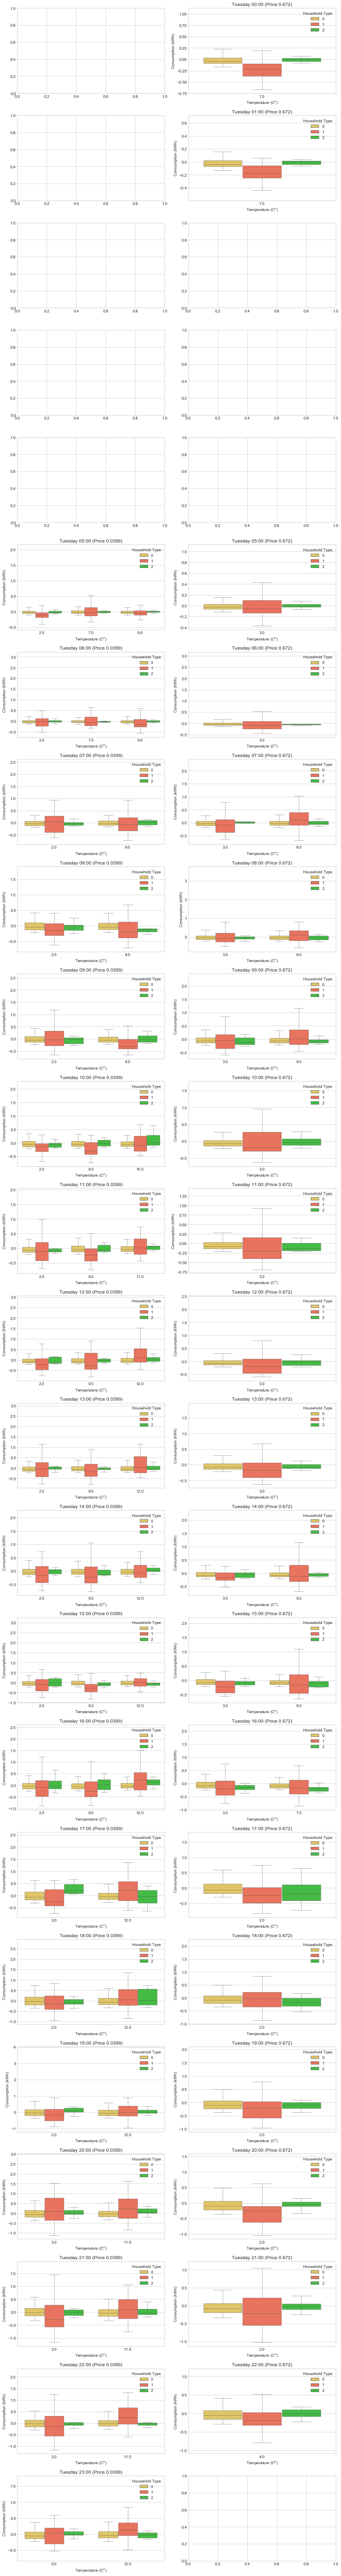

In [311]:
# Tuesday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 1 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)    
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

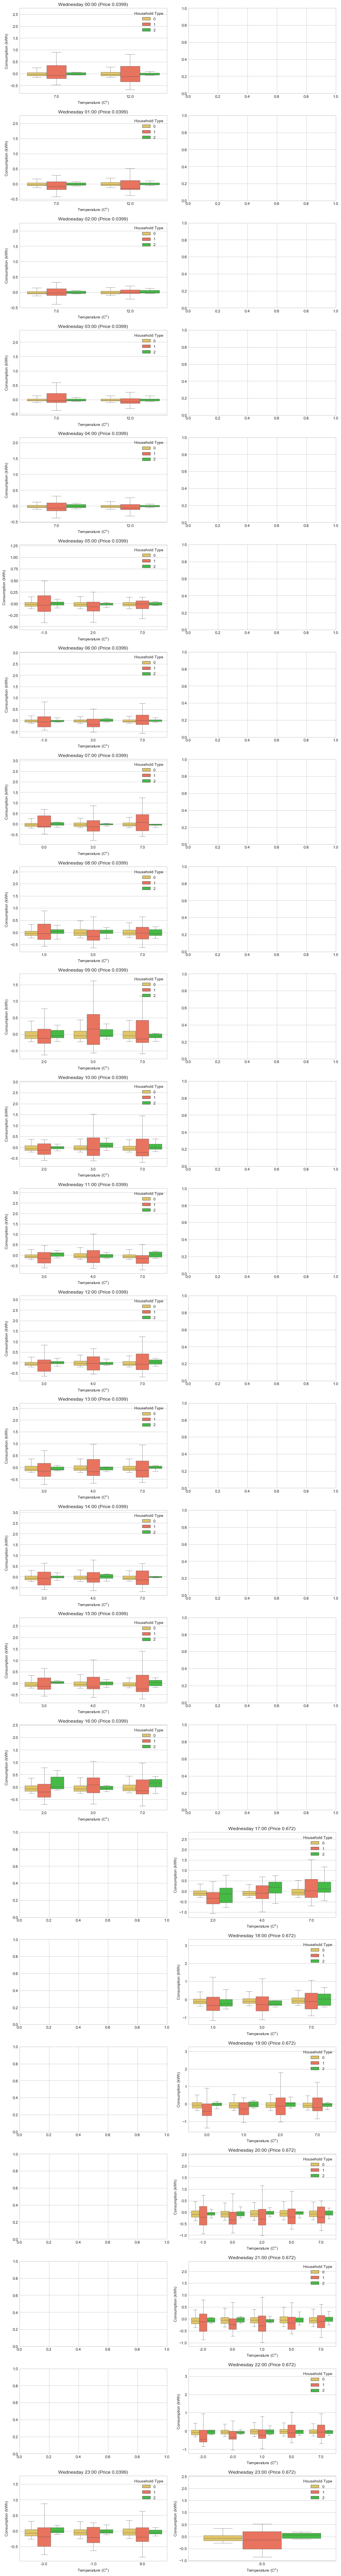

In [312]:
# Wednesday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 2 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)    
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')       
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

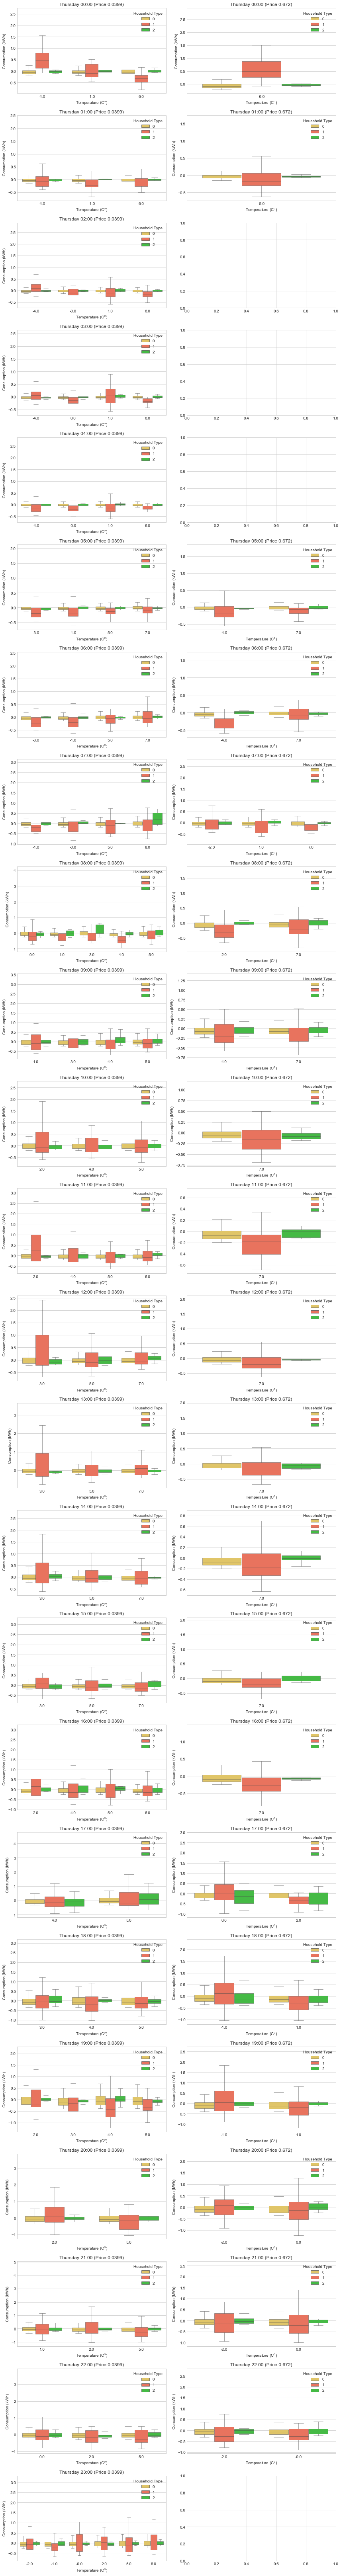

In [313]:
# Thursday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 3 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)        
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')   
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

In [1]:
# Friday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 4 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')      
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], showfliers=False)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

NameError: name 'plt' is not defined

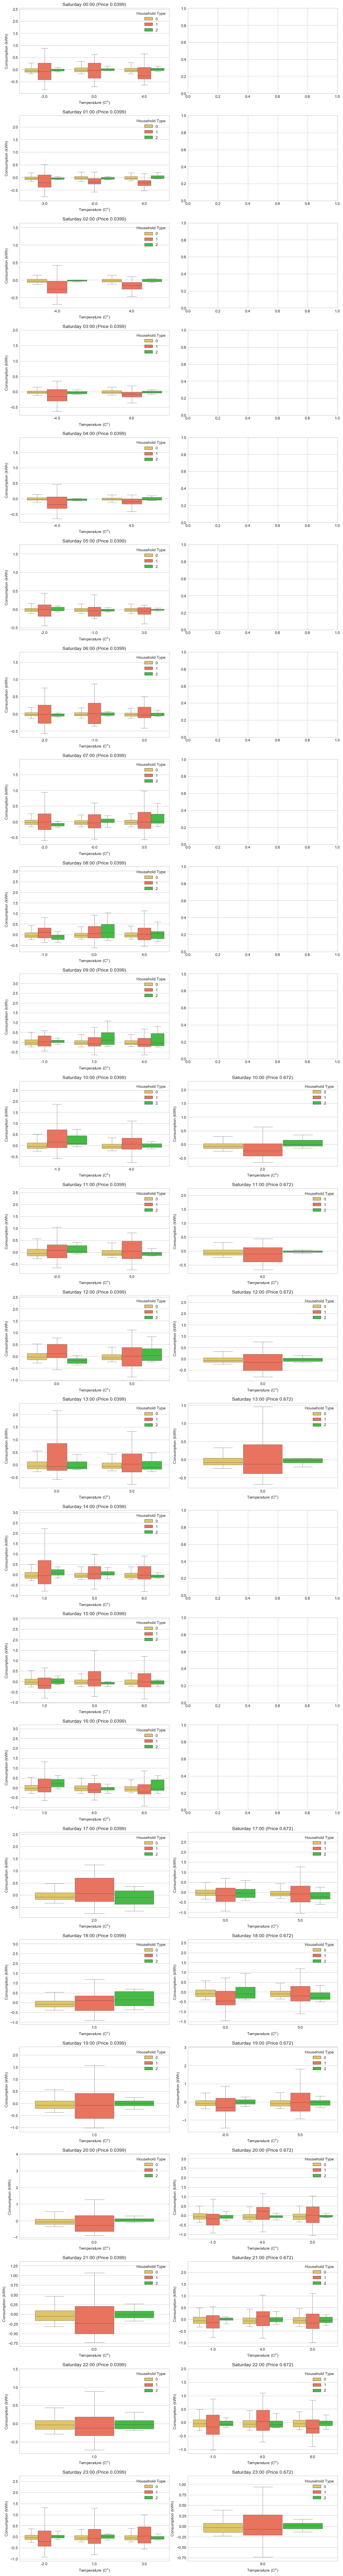

In [315]:
# Saturday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 5 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')      
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

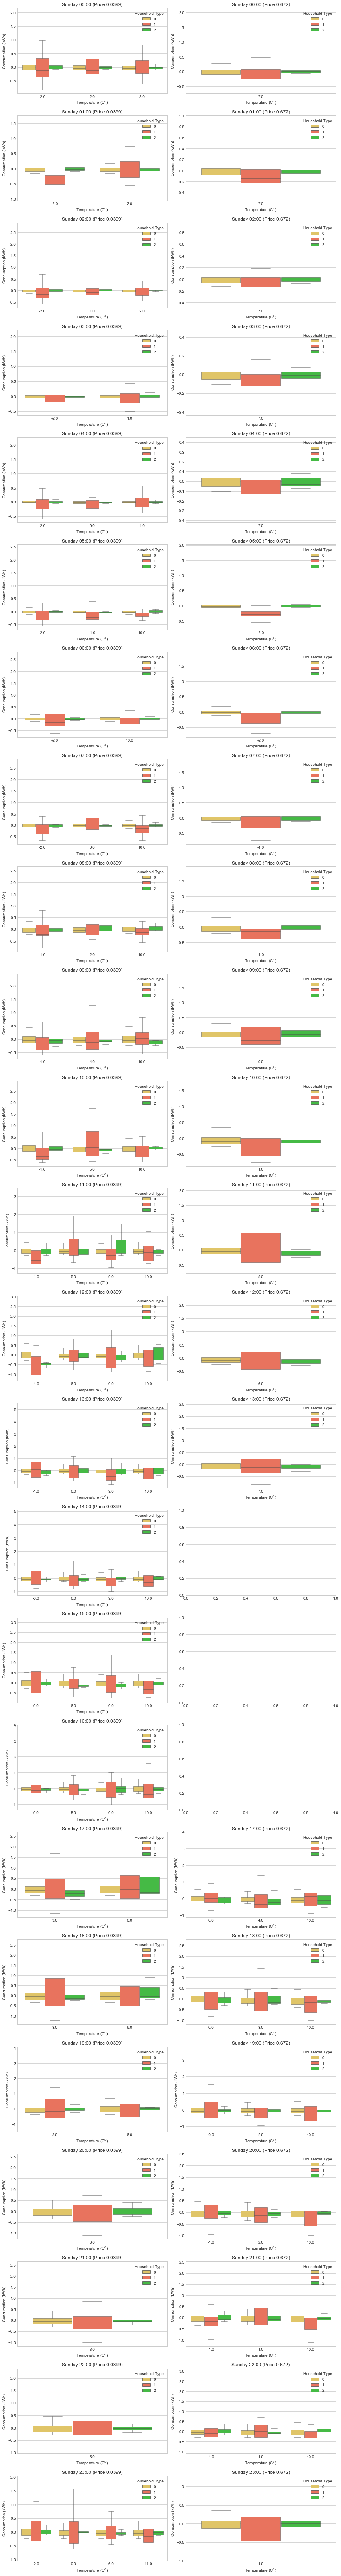

In [316]:
# Sunday hourly price responsiveness with different temperature and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
day_of_week = 6 # 0 is Monday, 6 is Sunday
df_day = df_all_res_long[df_all_res_long['Day of week'] == day_of_week]
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_day_hour = df_day[(df_day['Hour of day'] == i) & (df_day['Price'] == prices[p])]
        if df_day_hour.shape[0] >= 1:
            if i <= 9:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' 0' + str(i) + ':00 (Price ' + str(prices[p]) + ')' )
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)    
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')       
            else:
                sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
                ax_Ntou[-1].set_title(weeks[day_of_week] + ' ' + str(i) + ':00 (Price ' + str(prices[p]) + ')')
                ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
                ax_Ntou[-1].set_ylabel('Consumption (kWh)')
                l = ax_Ntou[-1].legend()
                l.set_title('Household Type')
                for i,artist in enumerate(ax_Ntou[-1].artists):
                    artist.set_linewidth(0.5)
                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    for j in range(i*6,i*6+6):
                        line = ax_Ntou[-1].lines[j]
                        line.set_linewidth(0.5)     
                ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

b) Day of week - hour : prices

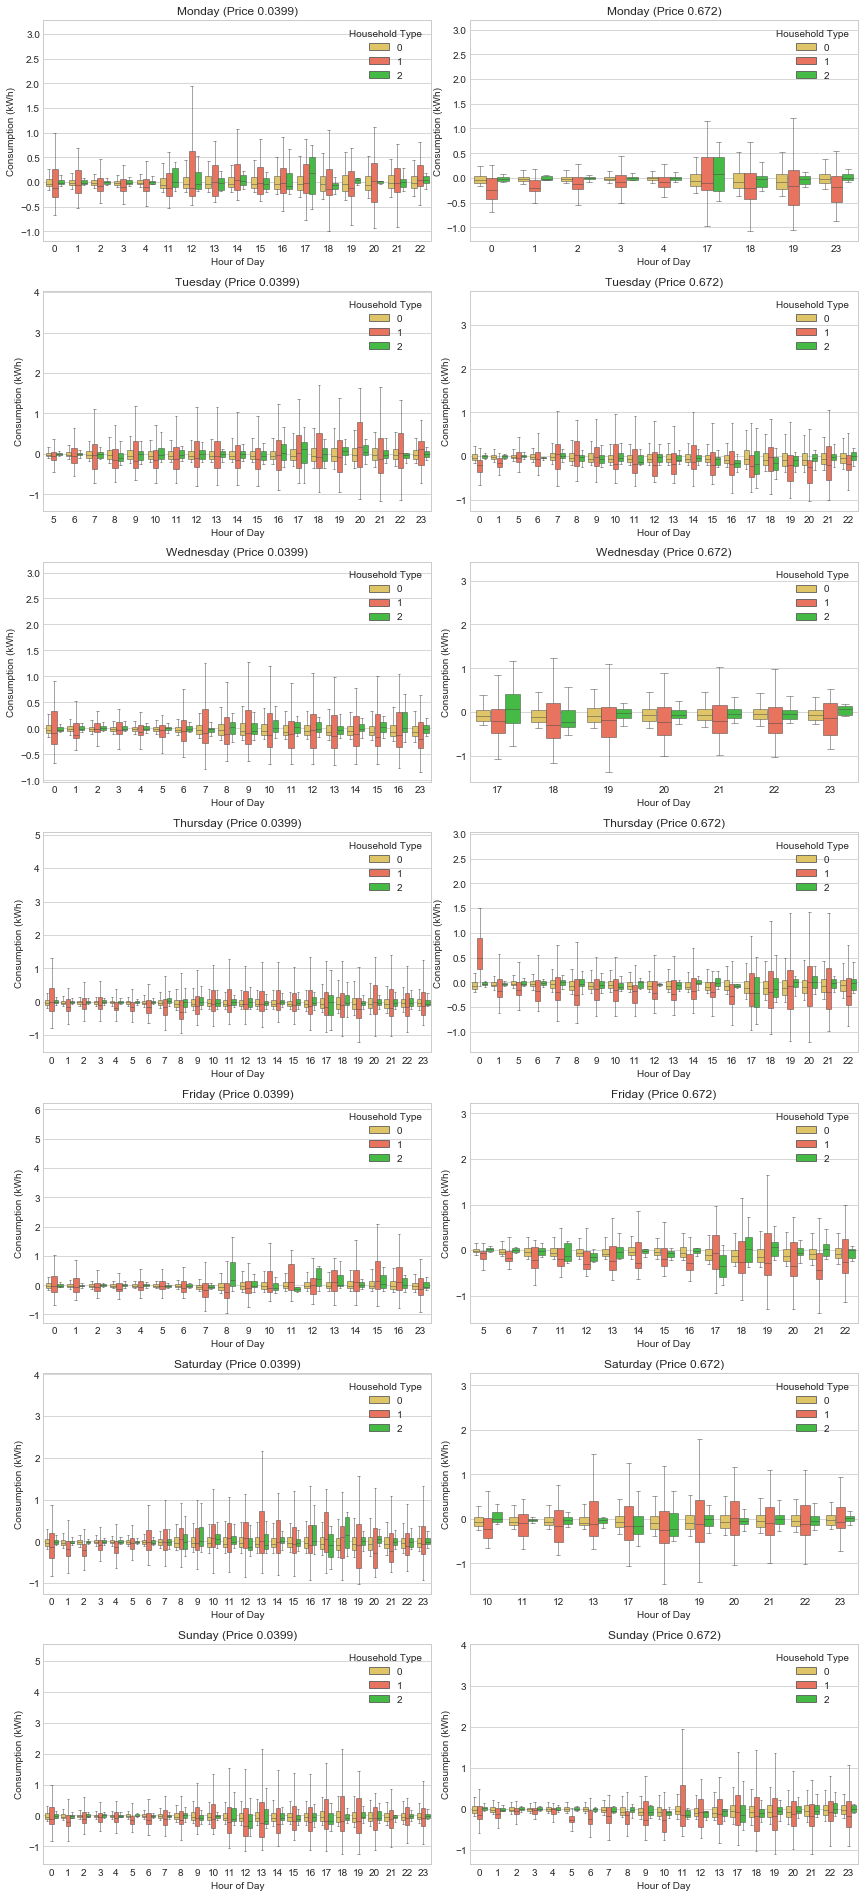

In [317]:
# hourly price responsiveness over days of week and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
for p in range(2): # two price levels
    for day_of_week in range(7):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * day_of_week + (p + 1)))
        df_day = df_all_res_long[(df_all_res_long['Day of week'] == day_of_week) & (df_all_res_long['Price'] == prices[p])]
        if df_day.shape[0] >= 1:
            sns.boxplot(x="Hour of day", y="Consumption", hue="Household type", data=df_day, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
            ax_Ntou[-1].set_title(weeks[day_of_week]  + ' (Price ' + str(prices[p]) + ')' )
            ax_Ntou[-1].set_xlabel(r'Hour of Day')
            ax_Ntou[-1].set_ylabel('Consumption (kWh)')
            l = ax_Ntou[-1].legend()
            l.set_title('Household Type')
            for i,artist in enumerate(ax_Ntou[-1].artists):
                artist.set_linewidth(0.5)
                # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                # Loop over them here, and use the same colour as above
                for j in range(i*6,i*6+6):
                    line = ax_Ntou[-1].lines[j]
                    line.set_linewidth(0.5)    
            ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

Friday night, Saturday night and Sunday night show an intersting pattern: on Friday night, people's price responsiveness increases, but on Saturday night, the price responstiveness become negative to low price meaning people simply use less energy even though it's a cheaper electricity price time period; Last on Sunday night, the price responsiveness recover to the balanced point.

c) Day of week - temperature : prices

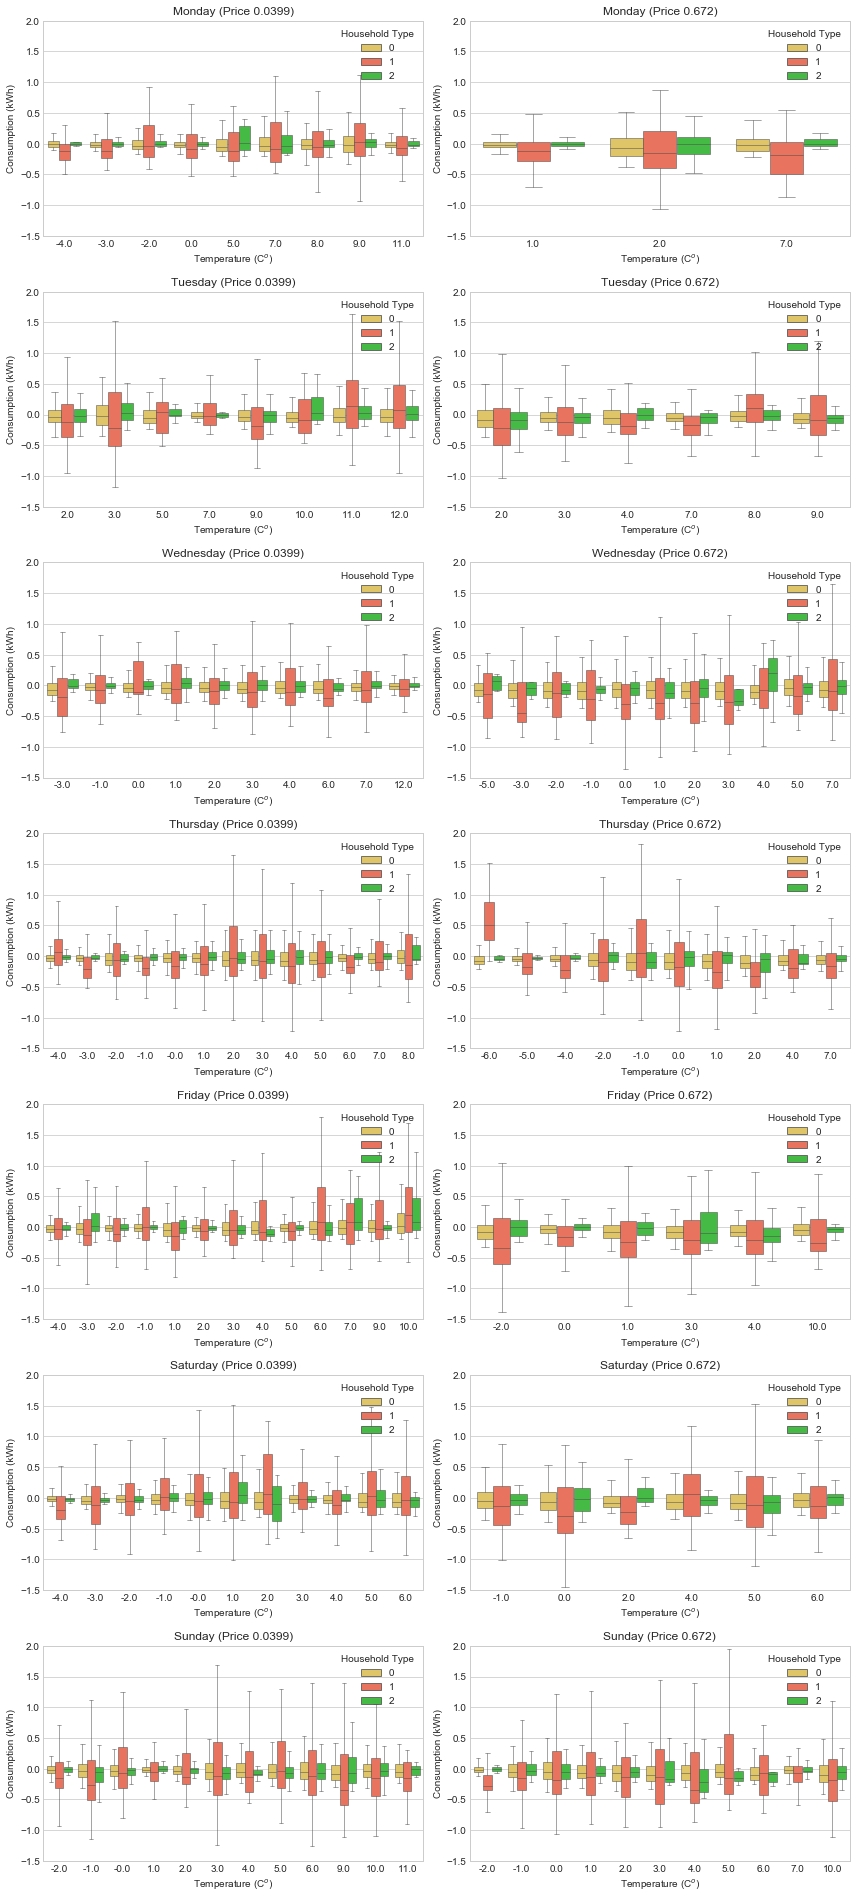

In [364]:
# price responsiveness under different tempertures over days of week and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
for p in range(2): # two price levels
    for day_of_week in range(7):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * day_of_week + (p + 1)))
        df_day = df_all_res_long[(df_all_res_long['Day of week'] == day_of_week) & (df_all_res_long['Price'] == prices[p])]
        if df_day.shape[0] >= 1:
            sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_day, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
            ax_Ntou[-1].set_title(weeks[day_of_week]  + ' (Price ' + str(prices[p]) + ')' )
            ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
            ax_Ntou[-1].set_ylabel('Consumption (kWh)')
            ax_Ntou[-1].set(ylim = (-1.5, 2))
            l = ax_Ntou[-1].legend()
            l.set_title('Household Type')
            for i,artist in enumerate(ax_Ntou[-1].artists):
                artist.set_linewidth(0.5)
                # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                # Loop over them here, and use the same colour as above
                for j in range(i*6,i*6+6):
                    line = ax_Ntou[-1].lines[j]
                    line.set_linewidth(0.5)    
            ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

Household type 1 has a wider range of price responsiveness, we could may be focus more on studying of these type of users. 

d) Hour of day - temperature : prices

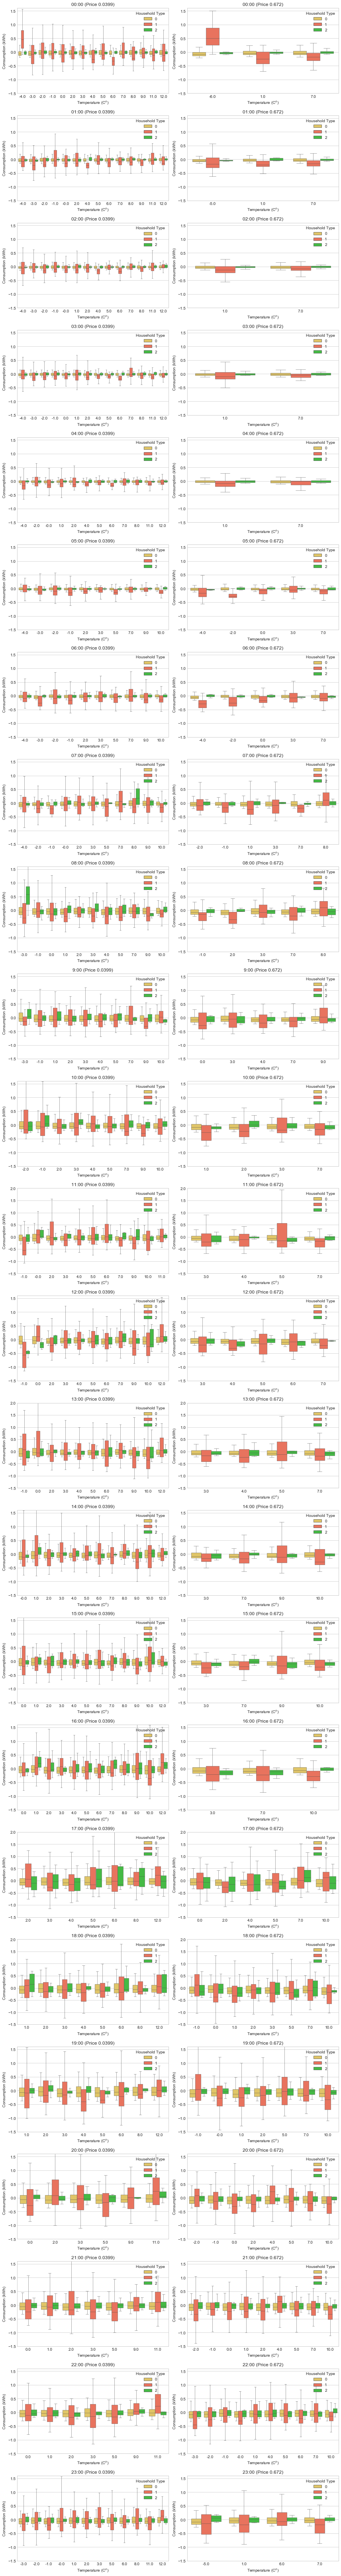

In [363]:
# hourly price responsiveness over temperatures and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
for p in range(2): # two price levels
    for i in range(24):
        ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * i + (p + 1)))
        df_hour = df_all_res_long[(df_all_res_long['Hour of day'] == i) & (df_all_res_long['Price'] == prices[p])]
#         min_consumption = df_hour['Consumption'].min()
#         max_consumption = df_hour['Consumption'].max()
        if df_hour.shape[0] >= 1:
            sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_hour, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
            if i < 9:
                ax_Ntou[-1].set_title('0' + str(i) + ':00' + ' (Price ' + str(prices[p]) + ')' )
            else:
                ax_Ntou[-1].set_title(str(i) + ':00' + ' (Price ' + str(prices[p]) + ')' )
            ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
            ax_Ntou[-1].set_ylabel('Consumption (kWh)')
            if i == 11 or i == 13 or i == 17 or i == 18:
                ax_Ntou[-1].set(ylim = (-1.5, 2))
            else:
                ax_Ntou[-1].set(ylim = (-1.5, 1.6))
            l = ax_Ntou[-1].legend()
            l.set_title('Household Type')
            for i,artist in enumerate(ax_Ntou[-1].artists):
                artist.set_linewidth(0.5)
                # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                # Loop over them here, and use the same colour as above
                for j in range(i*6,i*6+6):
                    line = ax_Ntou[-1].lines[j]
                    line.set_linewidth(0.5)    
            ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

See 22:00 low price picture, it's clear that when temperature is higher the reponsiveness to low price increases.

When temperature is low enough, high price won't stop people consume energy

e) Day of week: prices

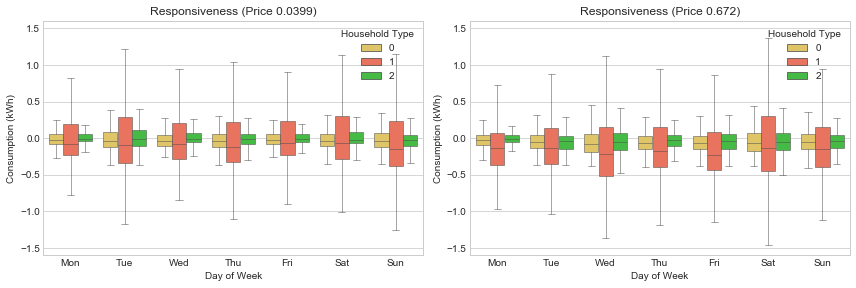

In [355]:
# price responsiveness under different tempertures over days of week and prices
fig_all = plt.figure(figsize = (12,90))
ax_Ntou = [] # store subplot objects
weeks = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
for p in range(2): # two price levels
    ax_Ntou.append(fig_all.add_subplot(24, 2, 2 * day_of_week + (p + 1)))
    df_day = df_all_res_long[df_all_res_long['Price'] == prices[p]]
    if df_day.shape[0] >= 1:
        sns.boxplot(x="Day of week", y="Consumption", hue="Household type", data=df_day, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
        ax_Ntou[-1].set_title('Responsiveness'  + ' (Price ' + str(prices[p]) + ')' )
        ax_Ntou[-1].set_xlabel(r'Day of Week')
        ax_Ntou[-1].set_xticklabels(weeks)
        ax_Ntou[-1].set_ylabel('Consumption (kWh)')
        ax_Ntou[-1].set(ylim = (-1.6, 1.6))
        l = ax_Ntou[-1].legend()
        l.set_title('Household Type')
        for i,artist in enumerate(ax_Ntou[-1].artists):
            artist.set_linewidth(0.5)
            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax_Ntou[-1].lines[j]
                line.set_linewidth(0.5)    
        ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

By comparing the median change from 0 in two pictures, we find people are more sensitive to the high price than low price, because in high price the median has obivious drops.

f) Hour of day: prices

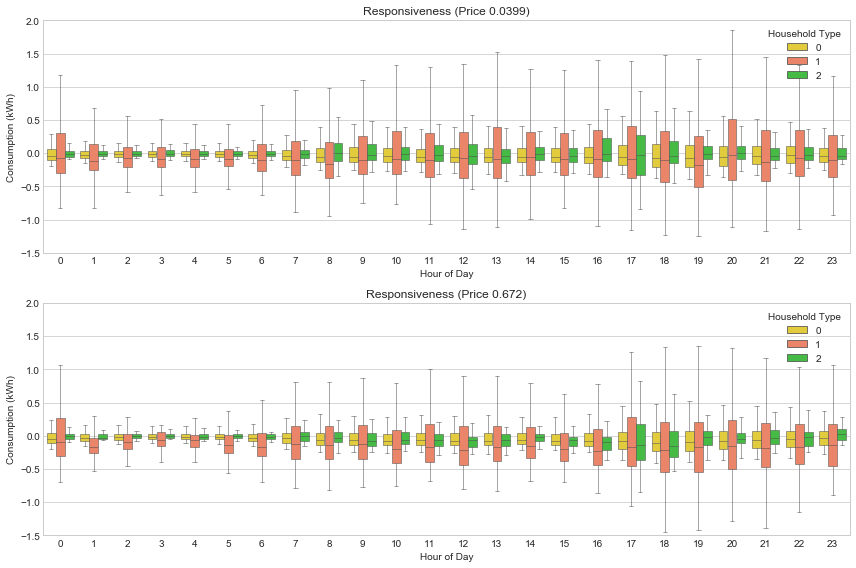

In [354]:
# price responsiveness under different tempertures over days of week and prices
fig_all = plt.figure(figsize = (12,8))
ax_Ntou = [] # store subplot objects
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
for p in range(2): # two price levels
    ax_Ntou.append(fig_all.add_subplot(2, 1, (p + 1)))
    df_hour = df_all_res_long[df_all_res_long['Price'] == prices[p]]
    if df_hour.shape[0] >= 1:
        sns.boxplot(x="Hour of day", y="Consumption", hue="Household type", data=df_hour, ax=ax_Ntou[-1], palette=['xkcd:sun yellow','xkcd:melon','limegreen'], fliersize = 0)
        ax_Ntou[-1].set_title('Responsiveness'  + ' (Price ' + str(prices[p]) + ')' )
        ax_Ntou[-1].set_xlabel(r'Hour of Day')
        ax_Ntou[-1].set_ylabel('Consumption (kWh)')
        ax_Ntou[-1].set(ylim = (-1.5, 2))
        l = ax_Ntou[-1].legend()
#         ax_Ntou[-1].yaxis.grid(True)
#         ax_Ntou[-1].xaxis.grid(True)
        l.set_title('Household Type')
        for i,artist in enumerate(ax_Ntou[-1].artists):
            artist.set_linewidth(0.5)
            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax_Ntou[-1].lines[j]
                line.set_linewidth(0.5)    
        ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

In a day, for low price, the max price responsivenss happens around 1pm (noon) and 8pm (evening); for high price the max responsiveness happens around 1pm and 6-7pm (evening).

Midnight doesn't have too much responsiveness potential. Also high price has more impact on the median behvaior for all household groups

g) Temperature: prices

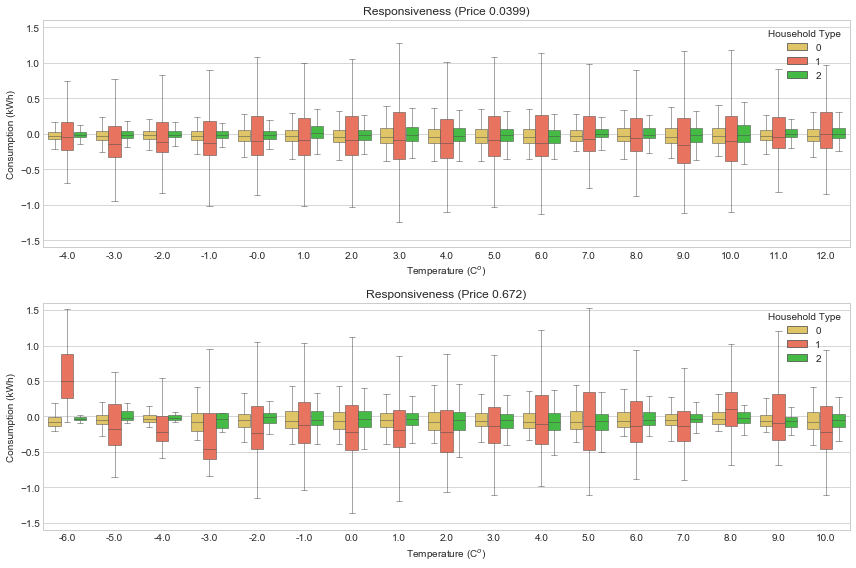

In [351]:
# price responsiveness under different tempertures over days of week and prices
fig_all = plt.figure(figsize = (12,8))
ax_Ntou = [] # store subplot objects
prices = [0.0399, 0.6720]
sns.set_style("whitegrid")
for p in range(2): # two price levels
    ax_Ntou.append(fig_all.add_subplot(2, 1, (p + 1)))
    df_temp = df_all_res_long[df_all_res_long['Price'] == prices[p]]
    if df_temp.shape[0] >= 1:
        sns.boxplot(x="TempC", y="Consumption", hue="Household type", data=df_temp, ax=ax_Ntou[-1], palette=['xkcd:maize','tomato','limegreen'], fliersize = 0)
        ax_Ntou[-1].set_title('Responsiveness'  + ' (Price ' + str(prices[p]) + ')' )
        ax_Ntou[-1].set_xlabel(r'Temperature (C$^o$)')
        ax_Ntou[-1].set_ylabel('Consumption (kWh)')
        ax_Ntou[-1].set(ylim = (-1.6, 1.6))
#         ax_Ntou[-1].yaxis.grid(True)
#         ax_Ntou[-1].xaxis.grid(True)
        l = ax_Ntou[-1].legend()
        l.set_title('Household Type')
        for i,artist in enumerate(ax_Ntou[-1].artists):
            artist.set_linewidth(0.5)
            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax_Ntou[-1].lines[j]
                line.set_linewidth(0.5)    
        ax_Ntou[-1].legend(loc = 'upper right').set_title('Household Type')
plt.tight_layout()

Still higher price shows more impacts on behavior's change.
Also, when temperate is lower to -6 celcius degree, the household type 1 increases their energy usage a significant amount no matter the high price. 